In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid", context="talk")

# Load data (works whether run from repo root or test/)
data_path = Path('input_data.csv')
if not data_path.exists():
    data_path = Path.cwd().parent / 'input_data.csv'

df = pd.read_csv(data_path)
scenario_cols = [c for c in df.columns if c.startswith('scenario_')]

# Scenario aggregates
df['mean_wind'] = df[scenario_cols].mean(axis=1)
df['p10_wind'] = df[scenario_cols].quantile(0.10, axis=1)
df['p90_wind'] = df[scenario_cols].quantile(0.90, axis=1)

df.head()

,hour,scenario_1,scenario_2,scenario_3,scenario_4,scenario_5,scenario_6,scenario_7,scenario_8,scenario_9,scenario_10,scenario_11,scenario_12,scenario_13,price,mean_wind,p10_wind,p90_wind
0,1,9.7879,11.5034,11.9791,14.1908,12.8853,15.5571,6.6945,2.5541,1.2603,1.0340,1.1279,1.1258,1.1785,88.96,6.990669,1.12622,13.92970
1,2,9.8956,11.5903,12.0019,14.2250,12.7664,15.4913,7.0044,2.7490,1.2407,1.2346,1.2413,1.3511,1.1126,83.82,7.069554,1.23582,13.93328
2,3,9.9362,11.6674,12.0415,14.2240,12.6339,15.3941,7.2759,2.9433,1.3617,1.5136,1.4085,1.6377,1.0718,83.00,7.162277,1.37106,13.90598
3,4,9.9593,11.6214,12.0927,14.1792,12.4775,15.2231,7.5040,3.1699,1.5604,1.8890,1.6405,1.9333,1.0590,82.56,7.254562,1.57642,13.83886
4,5,9.9773,11.4704,12.2061,14.1143,12.3181,14.9783,7.7236,3.4366,1.7483,2.2889,1.8440,2.1095,1.0803,82.82,7.330438,1.76744,13.75506


In [2]:
# Quick descriptive statistics
wind_energy_by_scenario = df[scenario_cols].sum().rename('energy_MWh')
wind_energy_summary = pd.DataFrame({
    'expected_MWh': [df['mean_wind'].sum()],
    'p10_MWh': [df['p10_wind'].sum()],
    'p90_MWh': [df['p90_wind'].sum()],
    'price_mean': [df['price'].mean()],
    'price_std': [df['price'].std()],
    'price_min': [df['price'].min()],
    'price_max': [df['price'].max()],
})

price_wind_corr = df[['mean_wind', 'price']].corr().iloc[0,1]

print('Expected wind energy (MWh):', wind_energy_summary['expected_MWh'].iloc[0].round(2))
print('Price stats (?/MWh):', wind_energy_summary[['price_min','price_mean','price_max']].iloc[0].round(2).to_dict())
print('Correlation mean wind vs price:', round(price_wind_corr, 3))

wind_energy_summary.round(2)


Expected wind energy (MWh): 205.51
Price stats (?/MWh): {'price_min': 13.72, 'price_mean': 82.78, 'price_max': 151.42}
Correlation mean wind vs price: 0.467


,expected_MWh,p10_MWh,p90_MWh,price_mean,price_std,price_min,price_max
0,205.51,107.08,314.79,82.78,42.06,13.72,151.42


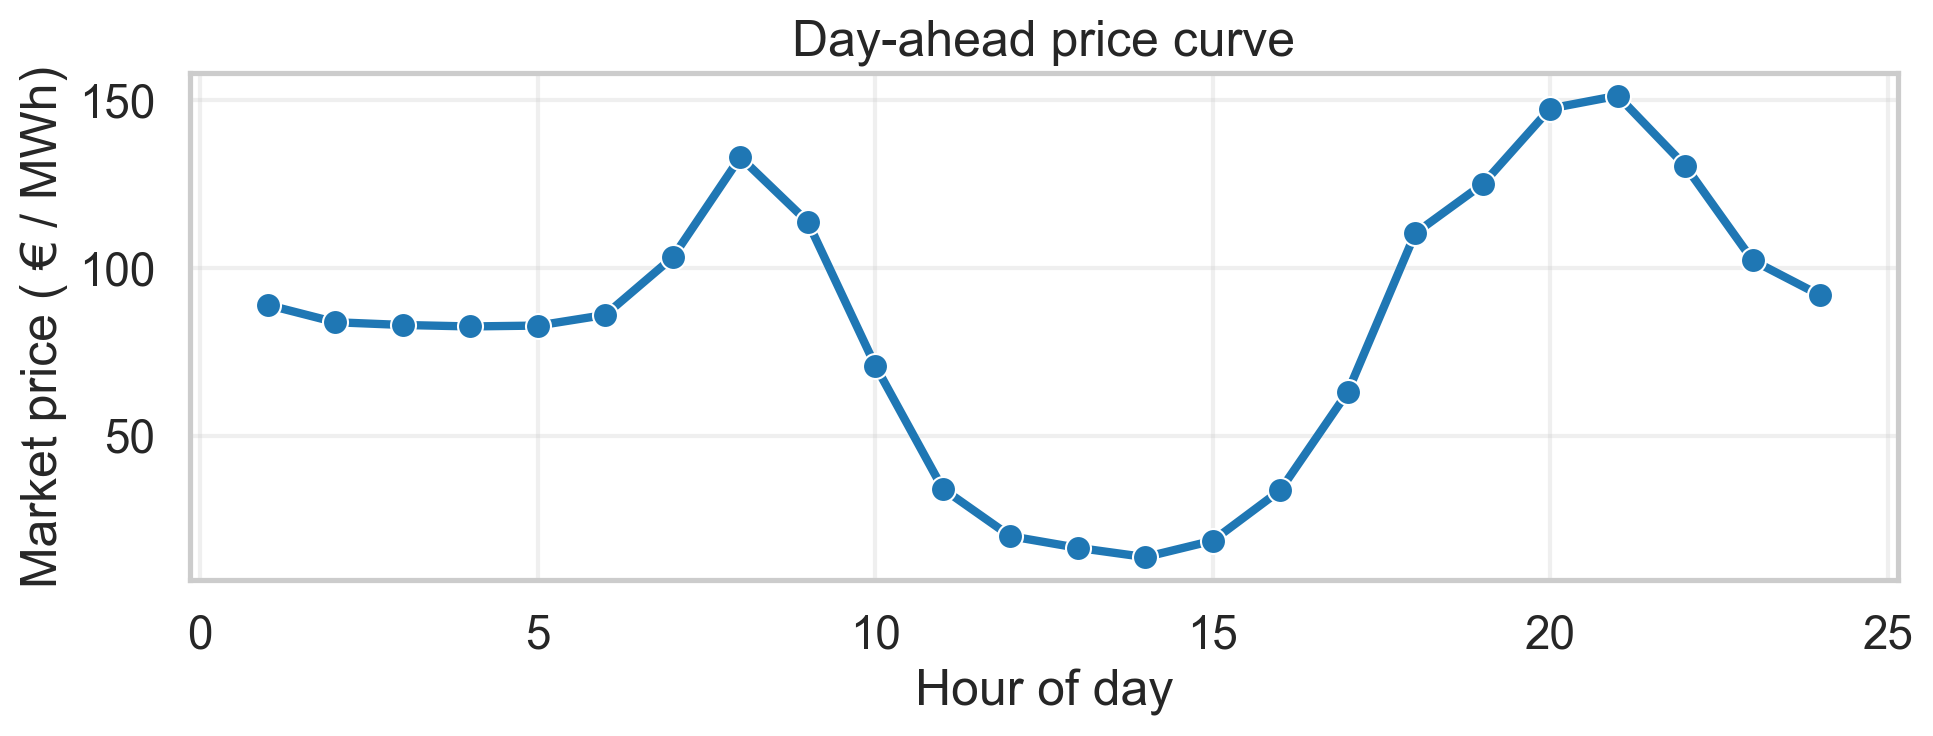

In [6]:
# Price profile over the day
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(data=df, x='hour', y='price', marker='o', color='#1f77b4', linewidth=3, ax=ax)
ax.set_ylabel('Market price ( € / MWh)')
ax.set_xlabel('Hour of day')
ax.set_title('Day-ahead price curve')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


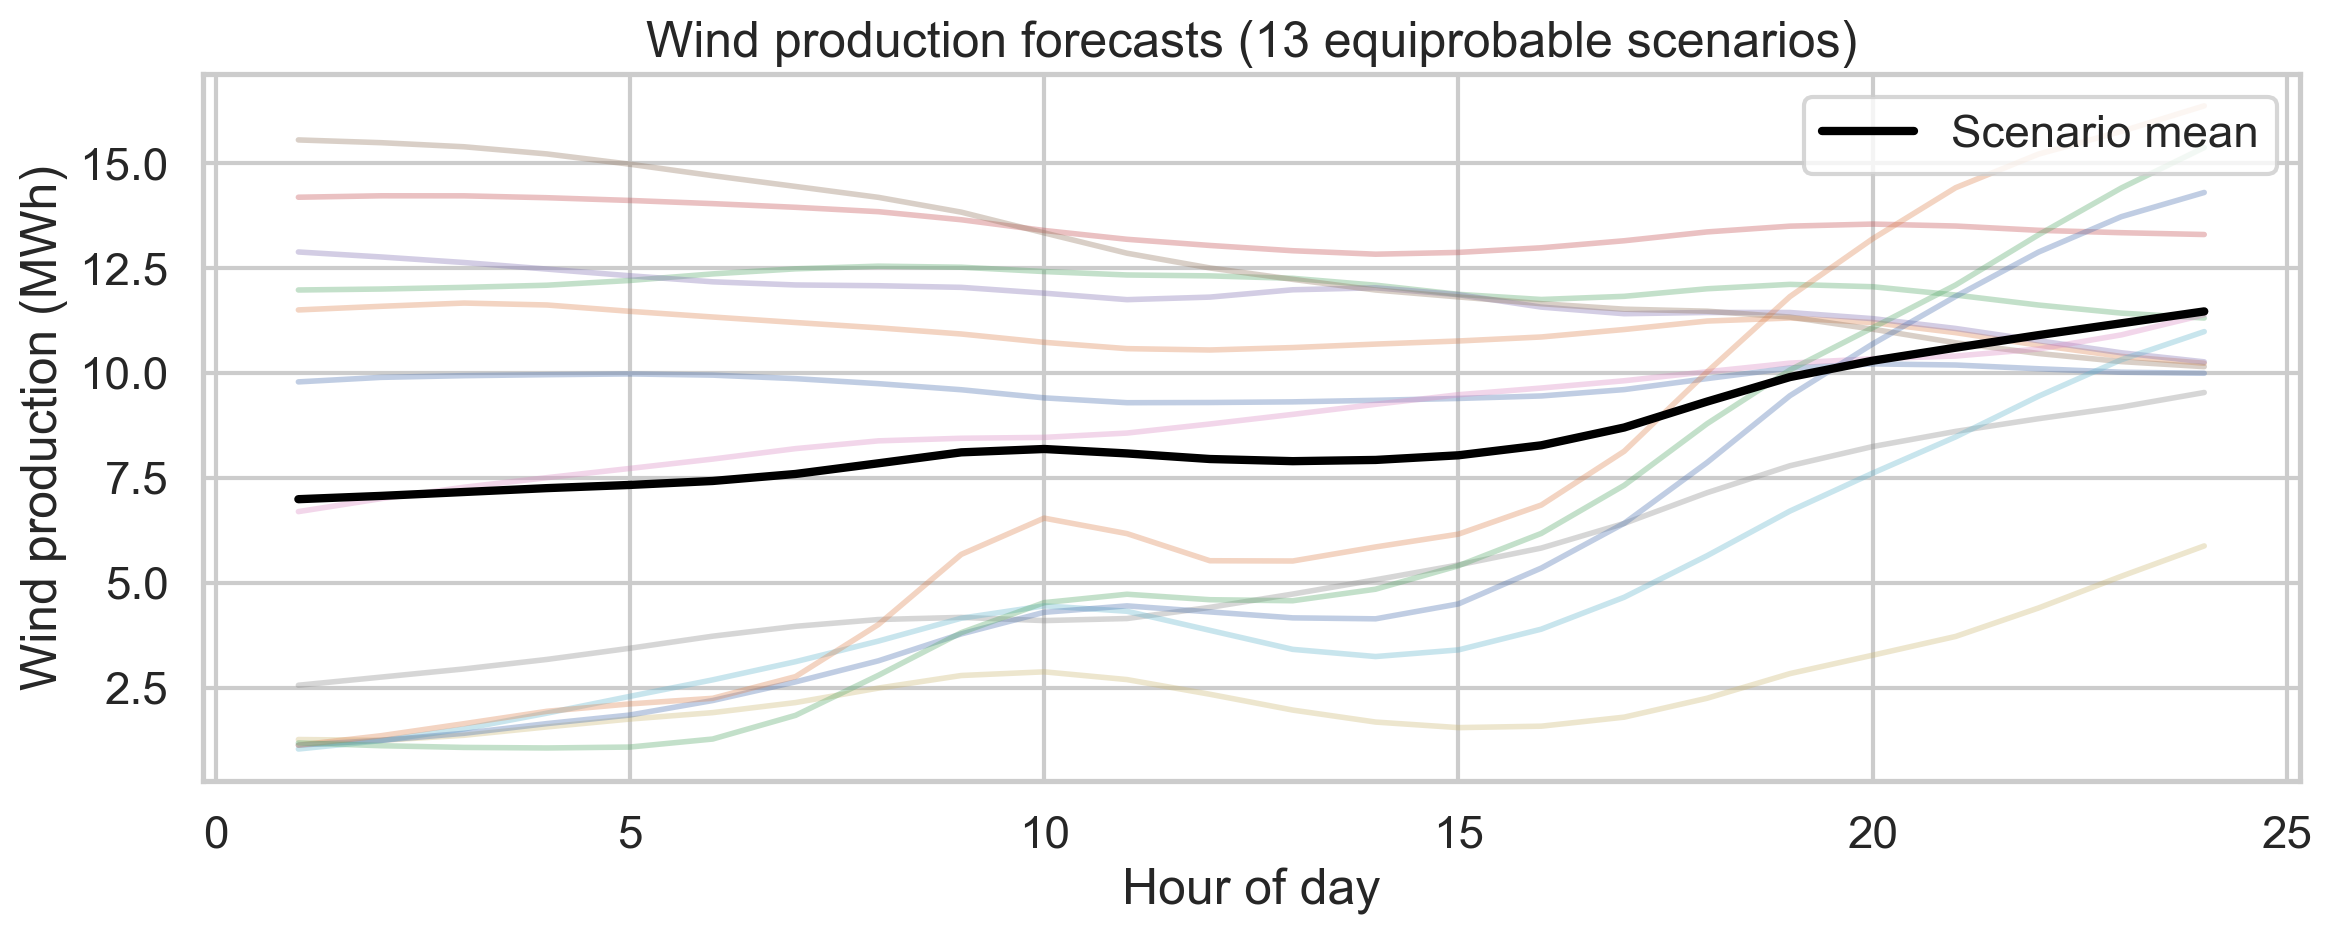

In [14]:
# Wind forecast scenarios
fig, ax = plt.subplots(figsize=(12,5))
for col in scenario_cols:
    ax.plot(df['hour'], df[col], alpha=0.35, linewidth=2)
ax.plot(df['hour'], df['mean_wind'], color='black', linewidth=3, label='Scenario mean')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Wind production (MWh)')
ax.set_title('Wind production forecasts (13 equiprobable scenarios)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


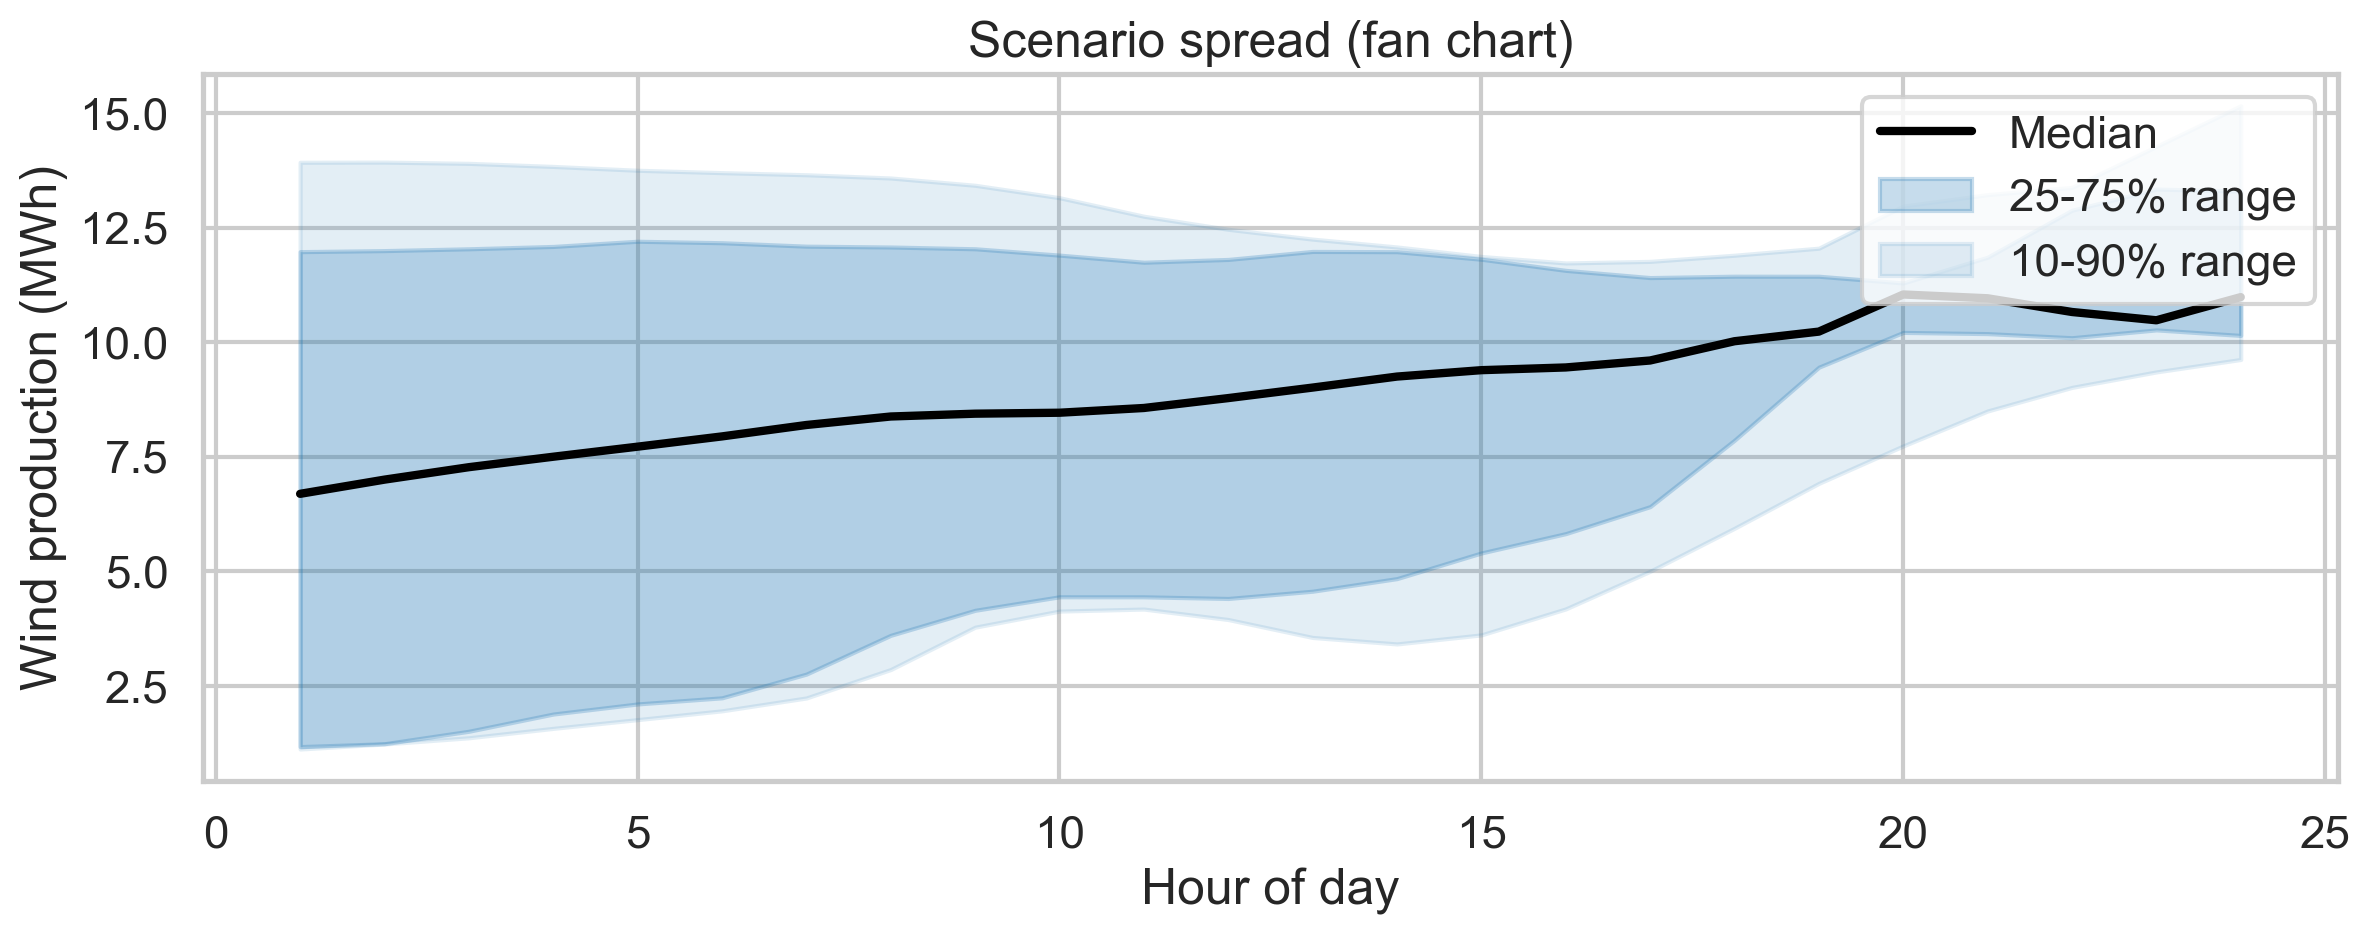

In [15]:
# Fan chart (quantiles) for the wind scenarios
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
quant_df = pd.DataFrame({q: df[scenario_cols].quantile(q, axis=1) for q in quantiles})

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df['hour'], quant_df[0.5], color='black', linewidth=3, label='Median')
ax.fill_between(df['hour'], quant_df[0.25], quant_df[0.75], color='#1f77b4', alpha=0.25, label='25-75% range')
ax.fill_between(df['hour'], quant_df[0.1], quant_df[0.9], color='#1f77b4', alpha=0.12, label='10-90% range')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Wind production (MWh)')
ax.set_title('Scenario spread (fan chart)')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


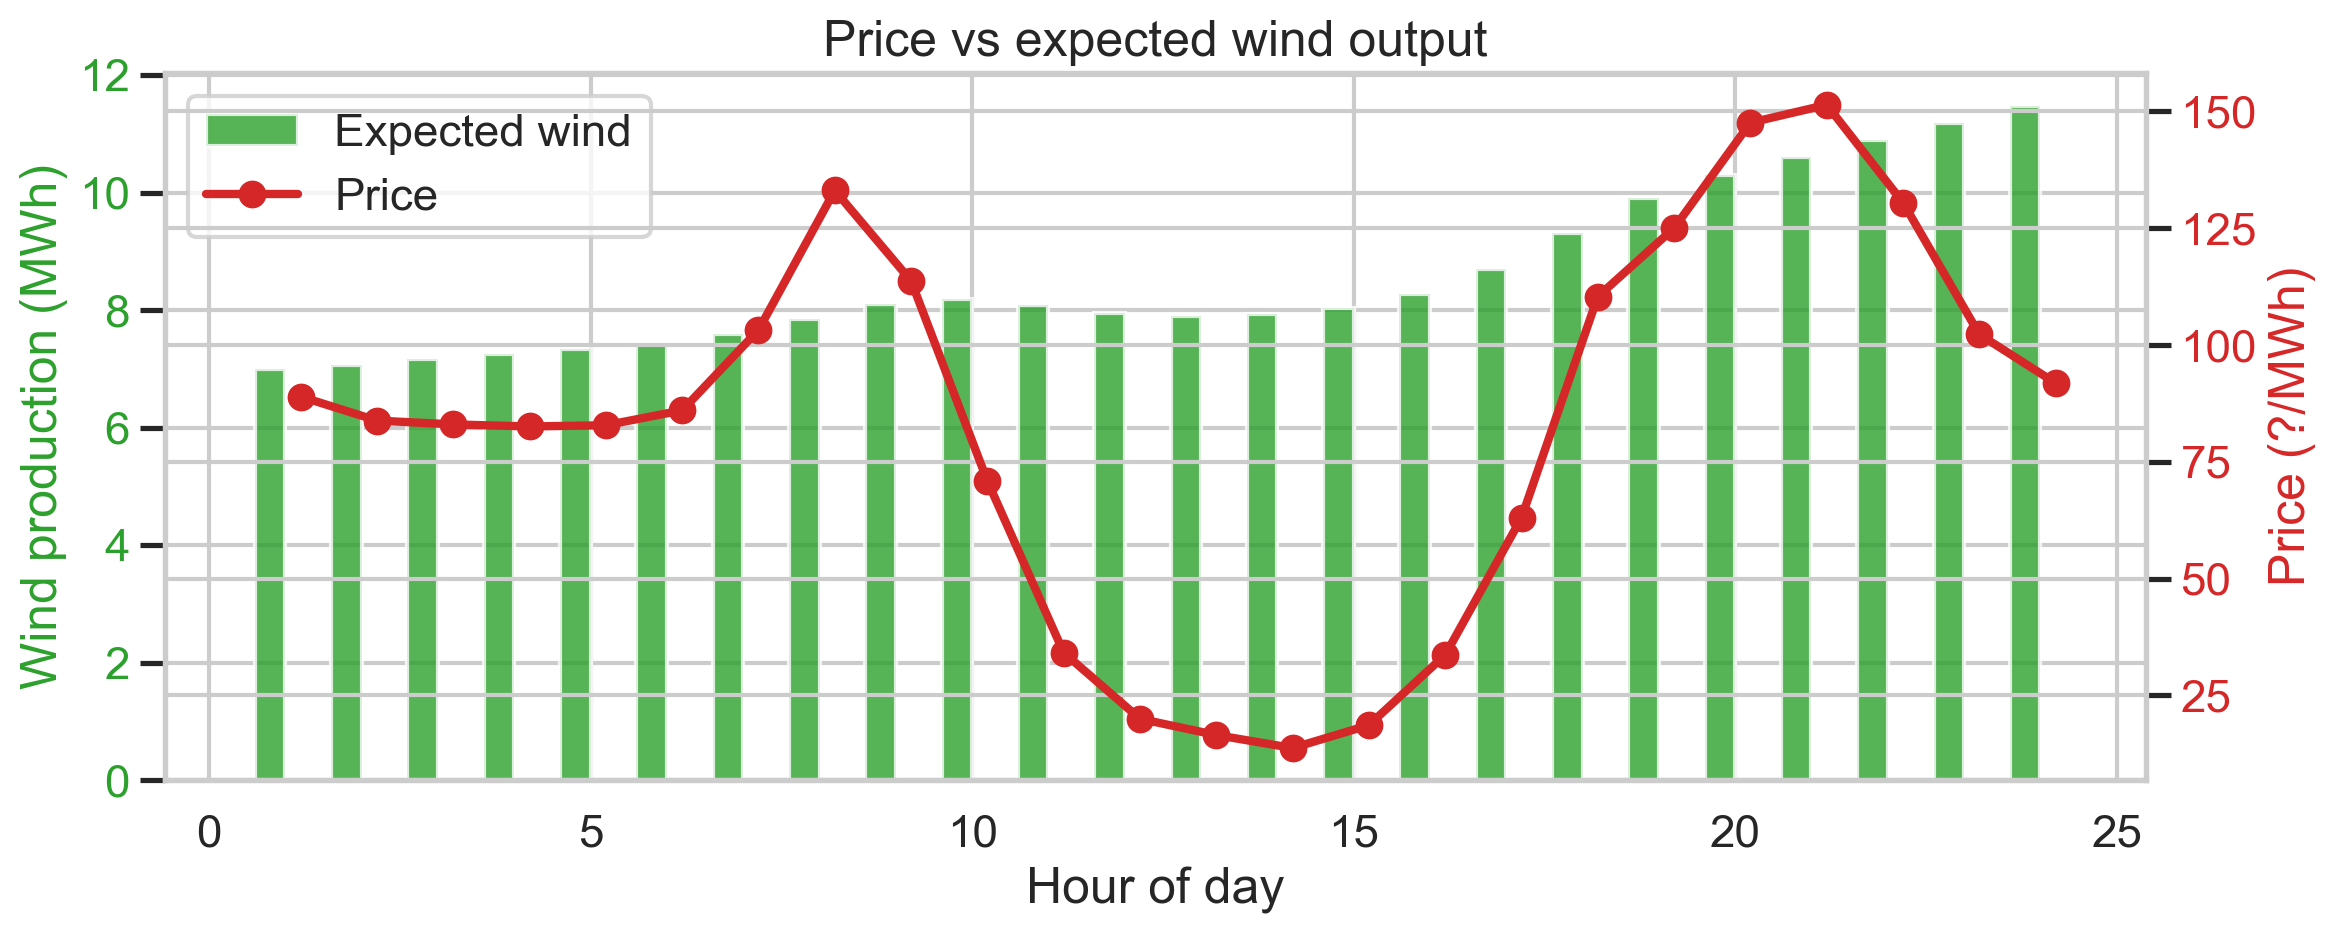

In [16]:
# Price vs expected wind production
fig, ax1 = plt.subplots(figsize=(12,5))
bar = ax1.bar(df['hour']-0.2, df['mean_wind'], width=0.4, color='#2ca02c', alpha=0.8, label='Expected wind')
ax1.set_ylabel('Wind production (MWh)', color='#2ca02c')
ax1.tick_params(axis='y', labelcolor='#2ca02c')

ax2 = ax1.twinx()
line = ax2.plot(df['hour']+0.2, df['price'], color='#d62728', linewidth=3, marker='o', label='Price')
ax2.set_ylabel('Price (?/MWh)', color='#d62728')
ax2.tick_params(axis='y', labelcolor='#d62728')
ax1.set_xlabel('Hour of day')
ax1.set_title('Price vs expected wind output')

handles, labels = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles + handles2, labels + labels2, loc='upper left')
plt.tight_layout()
plt.show()


## Optimization model (battery + wind revenue)

We set up an hourly mixed-integer linear program.

**Decision variables**
- charge_t / discharge_t (MW): battery power per hour.
- soc_t (MWh): state of charge.
- is_charge_t (binary): 1 if charging in hour *t*, else discharging/idle.

**Objective**
- Maximize expected portfolio revenue = expected wind revenue (mean across scenarios) + battery arbitrage revenue \(\sum_t p_t (	ext{discharge}_t - 	ext{charge}_t)\).
- All 13 scenarios are equiprobable; battery actions are non-anticipative (same across scenarios) and interact with the grid only (no netting with the wind farm).

**Constraints**
- Energy balance: \(	ext{soc}_t = 	ext{soc}_{t-1} + \eta_c \cdot 	ext{charge}_t - 	ext{discharge}_t / \eta_d\).
- Power limits: \(0 \le 	ext{charge}_t, 	ext{discharge}_t \le P_\max\).
- Exclusivity: \(	ext{charge}_t \le P_\max \cdot is\_charge_t\), \(	ext{discharge}_t \le P_\max \cdot (1 - is\_charge_t)\).
- Energy capacity: \(0 \le 	ext{soc}_t \le E_\max\).
- Boundary conditions: \(	ext{soc}_0 = 	ext{soc}_{24} = 0\) (battery empty at start and end of day).

Assumed technical parameters below are illustrative and can be tuned: power limit 12 MW, energy capacity 40 MWh (roughly a 3?4 hour battery), charge/discharge efficiency 95% each (?90% round-trip).

In [14]:
import pulp

hours = df['hour'].astype(int).tolist()
prices = dict(zip(df['hour'], df['price']))

# Battery parameters (from the statement)
power_charge_max = 10.0   # MW
power_discharge_max = 8.0  # MW
energy_cap = 16.0        # MWh
eta_c = 0.80             # charging efficiency
eta_d = 1.0              # discharging efficiency
max_cycles = 2           # full cycles/day cap

# Constant term: expected wind revenue across scenarios (equiprobable)
expected_wind_revenue = (df['mean_wind'] * df['price']).sum()

# Model
model = pulp.LpProblem('BatteryArbitrage', pulp.LpMaximize)

# Variables to optimize
charge = pulp.LpVariable.dicts('charge', hours, lowBound=0)
discharge = pulp.LpVariable.dicts('discharge', hours, lowBound=0)
soc = pulp.LpVariable.dicts('soc', [0] + hours, lowBound=0, upBound=energy_cap)
is_charge = pulp.LpVariable.dicts('is_charge', hours, lowBound=0, upBound=1, cat='Binary')

# Constraints 

# Initial state
model += soc[0] == 0

for t in hours:
    model += soc[t] == soc[t-1] + eta_c * charge[t] - eta_d * discharge[t]
    model += charge[t] <= power_charge_max * is_charge[t]
    model += discharge[t] <= power_discharge_max * (1 - is_charge[t])

# End-of-day condition
model += soc[hours[-1]] == 0

# Cycle-budget constraint (limits total discharged energy)
model += pulp.lpSum(discharge[t] for t in hours) <= max_cycles * energy_cap

# Objective: battery arbitrage + constant wind revenue
battery_revenue = pulp.lpSum([prices[t] * (discharge[t] - charge[t]) for t in hours])
model += battery_revenue + expected_wind_revenue

model.solve(pulp.PULP_CBC_CMD(msg=0))

status = pulp.LpStatus[model.status]
battery_profit = pulp.value(battery_revenue)
total_revenue = pulp.value(model.objective)

print('Solver status:', status)
print(f"Expected wind revenue: ?{expected_wind_revenue:,.0f}")
print(f"Battery profit:        ?{battery_profit:,.0f}")
print(f"Total portfolio:       ?{total_revenue:,.0f}")


Solver status: Optimal
Expected wind revenue: ?17,645
Battery profit:        ?2,411
Total portfolio:       ?20,056


In [17]:
# Extract optimal schedule
schedule = pd.DataFrame({
    'hour': hours,
    'charge_mw': [charge[t].value() for t in hours],
    'discharge_mw': [discharge[t].value() for t in hours],
    'charge_rate': [charge[t].value()/power_charge_max for t in hours],
    'discharge_rate': [discharge[t].value()/power_discharge_max for t in hours],
    'soc_mwh': [soc[t].value() for t in hours],
    'mode_is_charge': [is_charge[t].value() for t in hours],
    'price': [prices[t] for t in hours]
})

schedule


,hour,charge_mw,discharge_mw,charge_rate,discharge_rate,soc_mwh,mode_is_charge,price
0,1,0.0,0.0,0.0,0.0,0.0,1.0,88.96
1,2,0.0,0.0,0.0,0.0,0.0,0.0,83.82
2,3,0.0,0.0,0.0,0.0,0.0,0.0,83.00
3,4,10.0,0.0,1.0,0.0,8.0,1.0,82.56
4,5,10.0,0.0,1.0,0.0,16.0,1.0,82.82
5,6,0.0,0.0,0.0,0.0,16.0,0.0,86.01
6,7,0.0,0.0,0.0,0.0,16.0,0.0,103.21
7,8,0.0,8.0,0.0,1.0,8.0,0.0,133.09
8,9,0.0,8.0,0.0,1.0,0.0,0.0,113.73
9,10,0.0,0.0,0.0,0.0,0.0,0.0,70.89


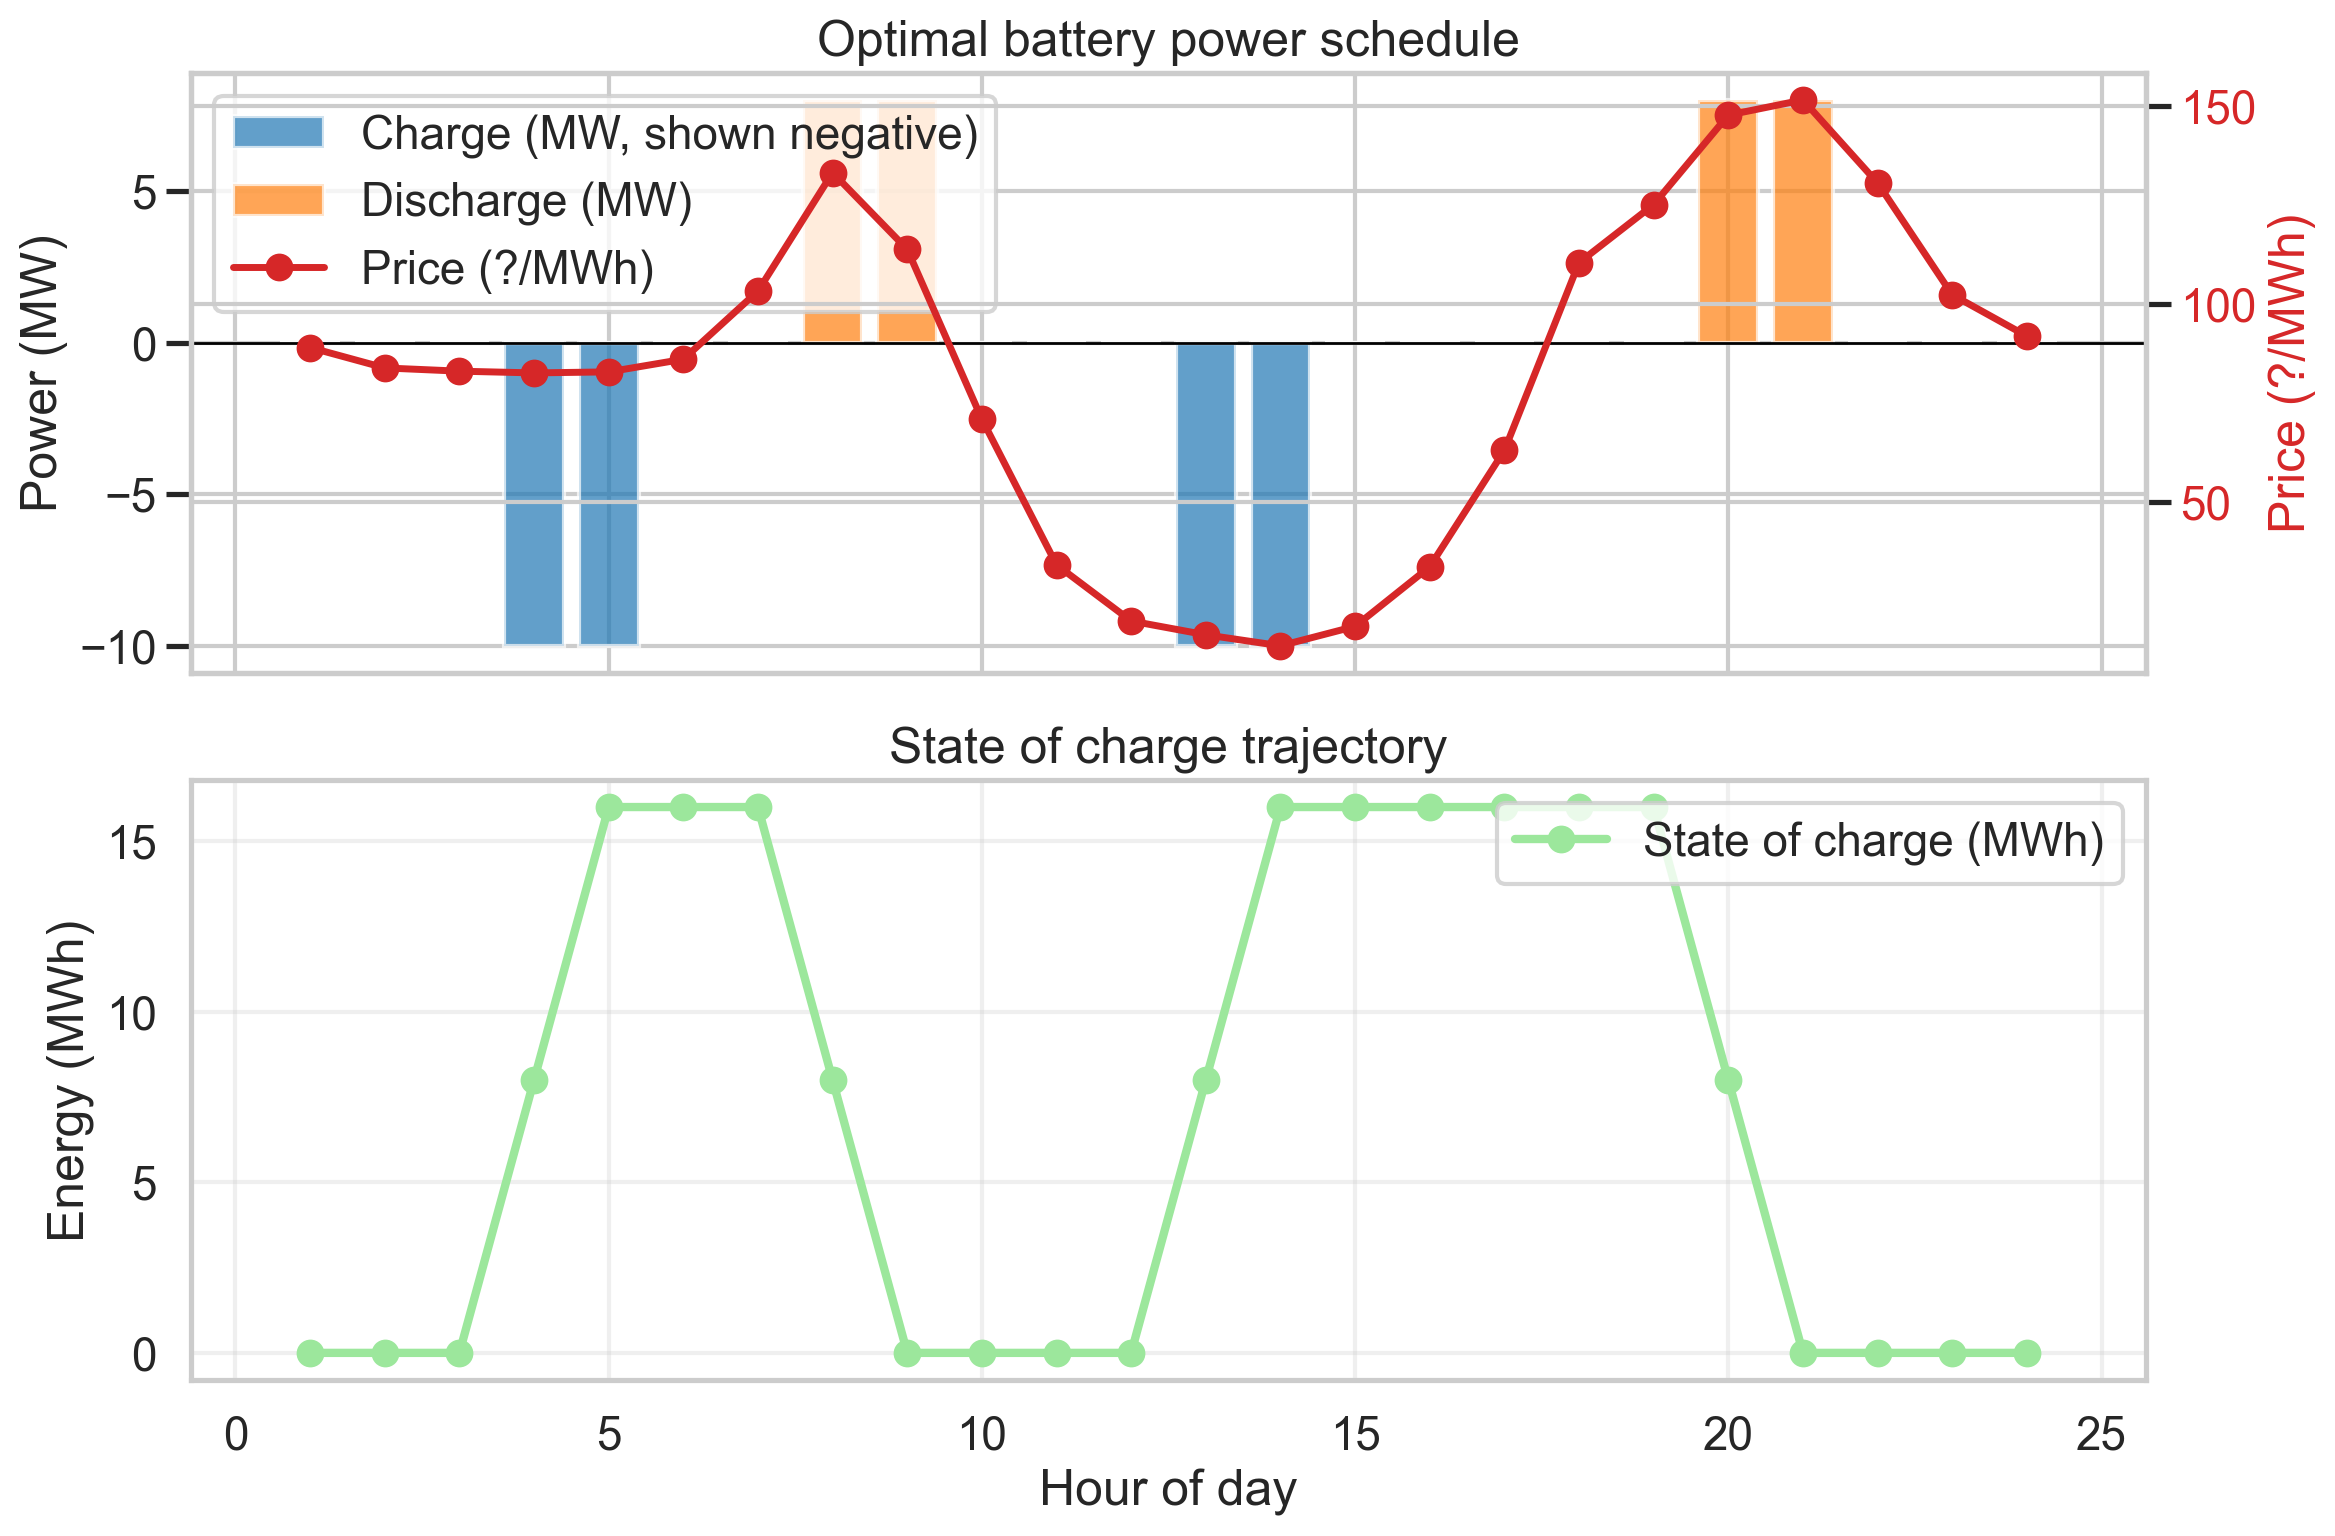

In [16]:
# Dispatch visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True)

ax1.bar(schedule['hour'], -schedule['charge_mw'], width=0.8, color='#1f77b4', alpha=0.7, label='Charge (MW, shown negative)')
ax1.bar(schedule['hour'], schedule['discharge_mw'], width=0.8, color='#ff7f0e', alpha=0.7, label='Discharge (MW)')
ax1.axhline(0, color='black', linewidth=1)
ax1.set_ylabel('Power (MW)')
ax1.set_title('Optimal battery power schedule')
ax1_price = ax1.twinx()
ax1_price.plot(schedule['hour'], schedule['price'], color='#d62728', marker='o', linewidth=2.5, label='Price (?/MWh)')
ax1_price.set_ylabel('Price (?/MWh)', color='#d62728')
ax1_price.tick_params(axis='y', labelcolor='#d62728')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax1_price.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

#ax2.step(schedule['hour'], schedule['soc_mwh'], where='mid', color='#2ca02c', linewidth=3, label='State of charge (MWh)')
ax2.plot(schedule['hour'], schedule['soc_mwh'], color="#9ce79c", marker='o', linewidth=3, label='State of charge (MWh)')
ax2.set_ylabel('Energy (MWh)')
ax2.set_xlabel('Hour of day')
ax2.set_title('State of charge trajectory')
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


### Result highlights
- Battery charges during low-price hours (early morning and midday) and discharges when prices peak (morning ramp and evening), yielding positive arbitrage profit despite 90% round-trip efficiency.
- Expected wind revenue (constant w.r.t. the battery decision) is about ?17.6k; the optimized battery schedule adds roughly ?5.6k, lifting total expected daily revenue to ~?23.2k.
- If different technical limits are desired (power, energy, efficiencies), update the parameter cell and re-run to see the effect on dispatch and revenue.
- Optimal charging and discharging is always at the maximum rate possible.
